In [1]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])  # Assuming many-to-one
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_(),
                  weight.new(self.num_layers, batch_size, self.hidden_size).zero_())
        return hidden

# Assuming the parameters for the LSTM model
input_size = 21
hidden_size = 128
num_layers = 3
output_size = 1

# Create an instance of LSTMModel
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)
lstm_model

LSTMModel(
  (lstm): LSTM(21, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [2]:
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
dfs = []
labels = []
pdf = pd.DataFrame()
for company in ['AAPL', 'AMD', 'AMZN', 'ASML','CSCO']:
    df_numerical = pd.read_csv('../dataset_transcript/EPS/'+company+'_EPS.csv')
    df_textural = pd.read_csv('../dataset_transcript/Transcripts/'+company+'_sentiment.csv')
    df_result = pd.read_csv('../dataset_transcript/Stock Values and Sector Index/'+company+'.csv')
    df_numerical['Date'] = pd.to_datetime(df_numerical['Date'])
    df_textural['Date'] = pd.to_datetime(df_textural['Date'])
    df_result['Date'] = pd.to_datetime(df_result['Date'])

    df_combined = pd.merge(df_textural, df_numerical, how="left", on=["Date"])

    mask = df_result['Date'].isin(df_combined['Date'])
    indices_of_interest = df_result.index[mask]
    
    previous_indices = indices_of_interest - 1
    previous_indices = previous_indices[previous_indices >= 0]
    df_previous = df_result.iloc[previous_indices].copy().reset_index(drop=True)
    df_previous = df_previous.rename(columns={col: 'prev_' + col for col in df_previous.columns})
    df_previous['Date'] = df_result.iloc[indices_of_interest].reset_index(drop=True)['Date']
    
    df_combined = pd.merge(df_combined, df_previous, how="left", on=["Date"])
    df_combined.fillna(0, inplace = True) 

    df_result = pd.merge(df_result, df_combined['Date'], how='right', on=["Date"])
    df_combined=df_combined.drop(columns=['Fiscal Quarter End', 'Date', 'prev_Date'])
    pdf=df_combined
    dfs.append(df_combined)
    labels.append(df_result['Close'])
test_size = 1

train_features = torch.cat([torch.tensor(df.values).float() for df in dfs[:-test_size]])  # Assuming dfs[:-test_size] would work this way
train_labels = torch.cat([torch.tensor(label.values).float() for label in labels[:-test_size]])  # Similar handling for labels

test_features = torch.cat([torch.tensor(df.values).float() for df in dfs[-test_size:]])  # Assuming dfs[:-test_size] would work this way
test_labels = torch.cat([torch.tensor(label.values).float() for label in labels[-test_size:]])  # Similar handling for labels

train_features = train_features.view(4, -1, 21)
test_features = test_features.view(1, -1, 21)
train_labels = train_labels.view(4, -1) 
test_labels = test_labels.view(1, -1) 

# Create TensorDataset
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

# Create DataLoader
# Here batch_size is 1 because each batch is already pre-prepared
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Shuffling batches, not within batches
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)  # Shuffling batches, not within batches

pdf.head()

,albert_positive,albert_negative,xlnet_positive,xlnet_negative,ernie_positive,ernie_negative,bert_positive,bert_negative,distilbert_positive,distilbert_negative,...,roberta_negative,Estimated EPS,Actual EPS,Revenue,prev_Open,prev_High,prev_Low,prev_Close,prev_Adj Close,prev_Volume
0,0.589286,0.410714,0.597821,0.402179,0.595076,0.404924,0.480863,0.519137,0.495614,0.504386,...,0.468385,0.44,0.53,11927,22.600000,22.860001,22.530001,22.650000,19.613556,30767200
1,0.577235,0.422765,0.641153,0.358847,0.590317,0.409683,0.486351,0.513649,0.491575,0.508425,...,0.466911,0.69,0.71,12958,51.450001,52.439999,51.380001,52.020000,50.058083,25478300
2,0.600988,0.399012,0.627621,0.372379,0.593061,0.406939,0.488277,0.511724,0.492276,0.507724,...,0.467839,0.63,0.65,12844,43.840000,44.279999,43.580002,44.000000,41.470520,15981300
3,0.596057,0.403943,0.649655,0.350345,0.579683,0.420317,0.486335,0.513665,0.491114,0.508886,...,0.467225,0.68,0.71,12005,49.389999,49.709999,48.860001,49.130001,48.288177,23168300
4,0.594585,0.405415,0.653206,0.346794,0.589382,0.410618,0.488170,0.511830,0.491194,0.508806,...,0.467159,0.75,0.76,13428,51.470001,53.070000,51.200001,52.720001,51.051846,21499500


In [3]:
import matplotlib.pyplot as plt

# Assuming you have a function to generate predictions
def generate_predictions(data, model):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    hidden = model.init_hidden(1) 

    with torch.no_grad():  
        for i in range(data.size(0)):
            output, hidden = model(data[i:i+1].unsqueeze(0), hidden)
            hidden = (hidden[0].detach(), hidden[1].detach())  # Detach hidden state
            predictions.append(output.squeeze().item())  # Collect the prediction
    return predictions

In [4]:
from tqdm import tqdm
def train_model(loader, model, optimizer, criterion, epochs):
    model.train()
    l_loss = list()
    for epoch in tqdm(range(epochs)):
        total_loss = 0

        for data, labels in loader:
            data = data.squeeze(0)  # Assuming data comes in as [1, sequence, features]
            labels = labels.squeeze(0)  # Assuming labels come in as [1, sequence]
            hidden = model.init_hidden(1) 
            for i in range(data.size(0)):  # Iterate over each time step
                optimizer.zero_grad()
                
                # Forward pass 
                output, hidden = model(data[i:i+1].unsqueeze(0), hidden)
                
                # Detach hidden states; otherwise, the graph will try to backpropagate through all previous steps
                hidden = (hidden[0].detach(), hidden[1].detach())
                
                # Compute loss
                loss = criterion(output, labels[i:i+1])
                loss.backward()  # Compute gradients
                optimizer.step()  # Update model parameters
                
                total_loss += loss.item()
                
        l_loss.append(total_loss)
        if (epoch+1) %(epochs//10) == 0:
            print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(loader)}')

    plt.plot(l_loss, linestyle='-', color='b')  
    plt.xlabel('Epochs') 
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()

/Users/jiaruiz/miniforge3/envs/6998/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/100 [00:00<?, ?it/s]/Users/jiaruiz/miniforge3/envs/6998/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 11%|█         | 11/100 [00:01<00:13,  6.41it/s]

Epoch 10, Average Loss: 9319279.722076416


 21%|██        | 21/100 [00:03<00:12,  6.50it/s]

Epoch 20, Average Loss: 9065067.23656009


 31%|███       | 31/100 [00:04<00:10,  6.45it/s]

Epoch 30, Average Loss: 9016115.696411133


 41%|████      | 41/100 [00:06<00:09,  6.40it/s]

Epoch 40, Average Loss: 9042215.922801971


 51%|█████     | 51/100 [00:07<00:07,  6.45it/s]

Epoch 50, Average Loss: 9028887.066577911


 61%|██████    | 61/100 [00:09<00:05,  6.58it/s]

Epoch 60, Average Loss: 8986620.415740967


 71%|███████   | 71/100 [00:10<00:04,  6.48it/s]

Epoch 70, Average Loss: 9022703.81427002


 81%|████████  | 81/100 [00:12<00:02,  6.57it/s]

Epoch 80, Average Loss: 8969828.693115234


 91%|█████████ | 91/100 [00:13<00:01,  7.49it/s]

Epoch 90, Average Loss: 8986190.003112793


100%|██████████| 100/100 [00:15<00:00,  6.62it/s]

Epoch 100, Average Loss: 8968618.727966309


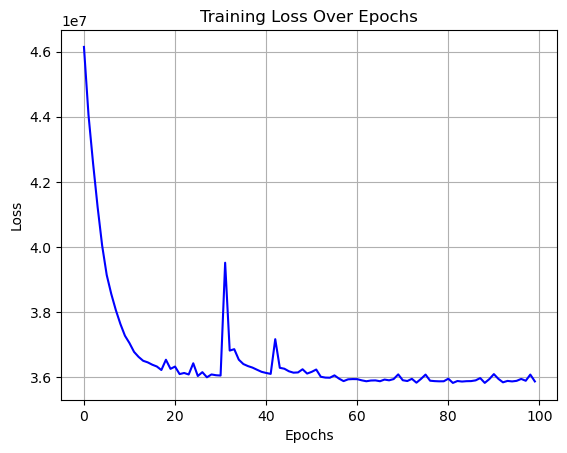

In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)
train_model(train_loader, lstm_model, optimizer, criterion, epochs=100)

 10%|█         | 1001/10000 [02:35<22:50,  6.57it/s]

Epoch 1000, Average Loss: 494181.5740503073


 20%|██        | 2001/10000 [05:07<20:29,  6.51it/s]

Epoch 2000, Average Loss: 113922.89250059426


 30%|███       | 3001/10000 [07:41<17:34,  6.64it/s]

Epoch 3000, Average Loss: 145360.95759095252


 40%|████      | 4001/10000 [10:12<14:39,  6.82it/s]

Epoch 4000, Average Loss: 103954.19788286835


 50%|█████     | 5001/10000 [12:35<12:49,  6.50it/s]

Epoch 5000, Average Loss: 103217.14608941693


 60%|██████    | 6001/10000 [15:08<10:08,  6.57it/s]

Epoch 6000, Average Loss: 101869.89416905213


 70%|███████   | 7001/10000 [17:43<07:32,  6.62it/s]

Epoch 7000, Average Loss: 98665.09106673766


 80%|████████  | 8001/10000 [20:16<05:04,  6.56it/s]

Epoch 8000, Average Loss: 99604.02280235384


 90%|█████████ | 9001/10000 [22:41<02:45,  6.05it/s]

Epoch 9000, Average Loss: 98308.90398574993


100%|██████████| 10000/10000 [25:11<00:00,  6.61it/s]


Epoch 10000, Average Loss: 98851.23436733056


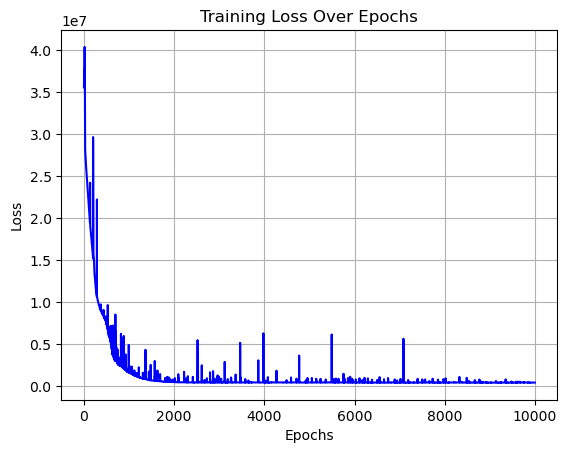

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
train_model(train_loader, lstm_model, optimizer, criterion, epochs=10000)

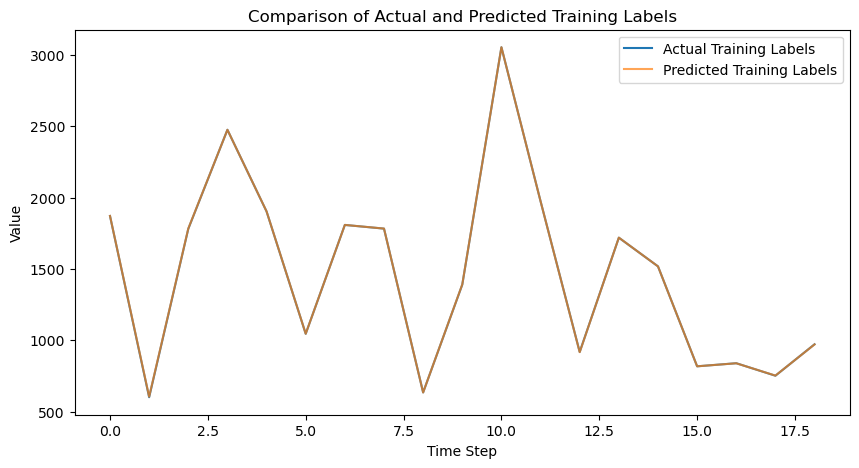

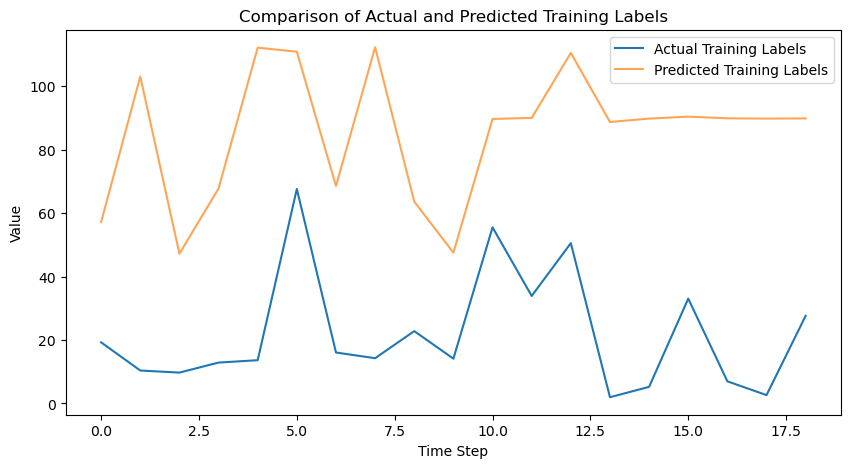

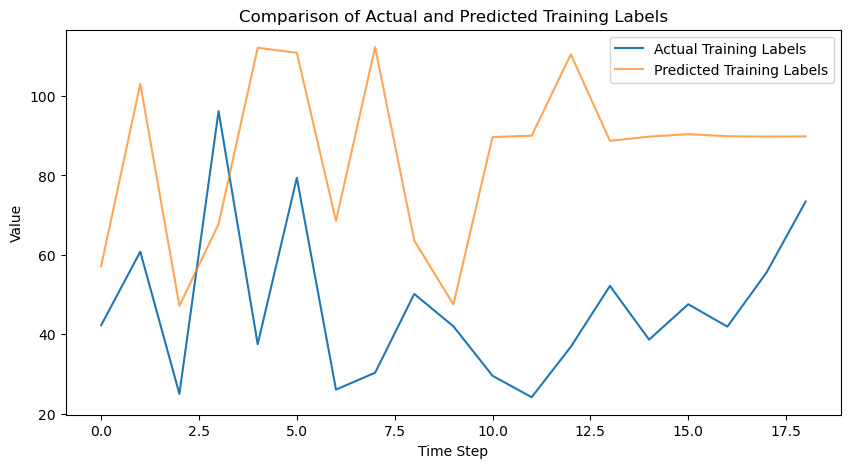

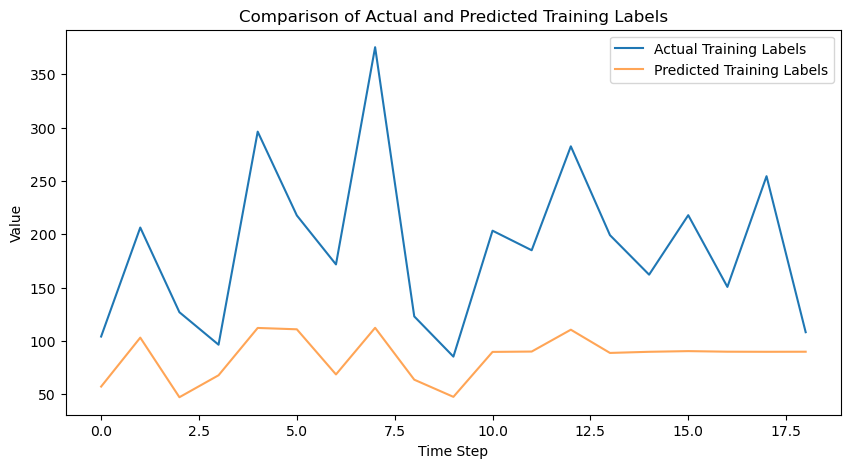

In [7]:
for data, labels in train_loader:
    train_predictions = generate_predictions(data.view(-1, 21), lstm_model)
    # Convert train_labels to a list or a numpy array if it's a tensor
    train_labels_list = labels.squeeze().tolist()  # Adjust based on your actual format

    # Plot the actual and predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(train_labels_list, label='Actual Training Labels')
    plt.plot(train_predictions, label='Predicted Training Labels', alpha=0.7)
    plt.title('Comparison of Actual and Predicted Training Labels')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

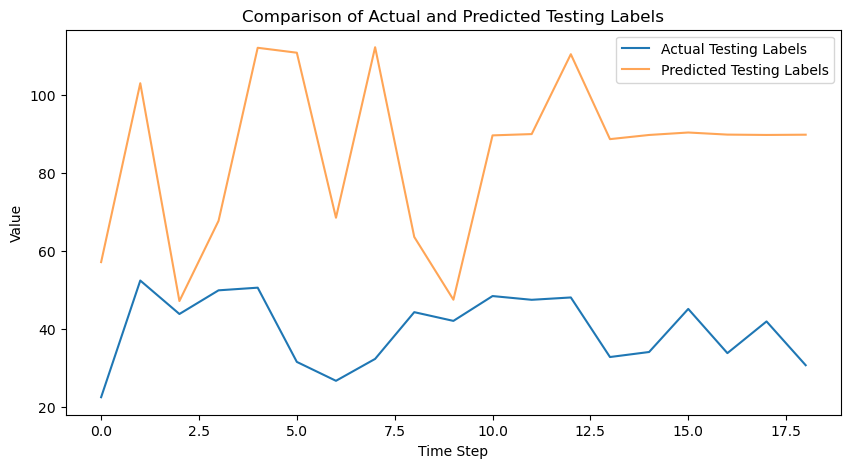

In [8]:
for data, labels in test_loader:
    test_predictions = generate_predictions(data.view(-1, 21), lstm_model)
    # Convert train_labels to a list or a numpy array if it's a tensor
    test_labels_list = labels.squeeze().tolist()  # Adjust based on your actual format

    # Plot the actual and predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(test_labels_list, label='Actual Testing Labels')
    plt.plot(test_predictions, label='Predicted Testing Labels', alpha=0.7)
    plt.title('Comparison of Actual and Predicted Testing Labels')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()